In [1]:
# Execute if necessary
# %%capture
!pip install openml qpsolvers
!pip install cvxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 KB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 KB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.3/468.3 KB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.6/298.6 KB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 89.8 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.13.1-py3-none-any.whl size=142800 sha256=51117d10a2bf1492e6a105e6e7f903bfcbdf5407e4b141f6e4a46a93421ef837
  Stored in directory: /root/.cache/pip/wheels/45/9a/36/e6701b6204a871ced537238ce7b5b2924a7408604bd301ad34
  Created whe

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
from sklearn.metrics import confusion_matrix
from qpsolvers import solve_qp
from mpl_toolkits.mplot3d import axes3d
import cvxopt

# Práctica 6: Máquinas de Vectores de Soporte

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Genera un dataset de clasificación binaria $\pm1$, de veinte instancias, aleatorio, de dos características, que sea linealmente separable. Grafique el dataset generado y coloree los puntos deacuerdo a su etiqueta.

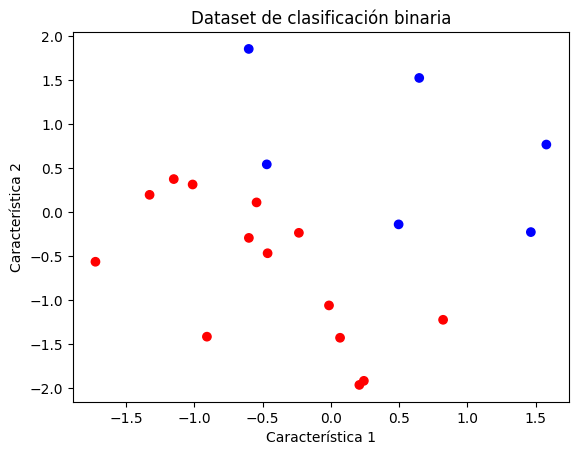

In [3]:
np.random.seed(42)

X = np.random.randn(20, 2)

# Generar etiquetas linealmente separables
y = np.where(X[:, 0] + X[:, 1] > 0, 1, -1)

# Colorear los puntos según su etiqueta
colors = np.where(y == 1, 'blue', 'red')

plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Dataset de clasificación binaria')
plt.show()


## Asignación 2

Genera un dataset de clasificación binaria $\pm1$, de veinte instancias, aleatorio, de dos características, que contenga todos los puntos de una clase entre dos parábolas y los puntos por arriba o por debajo de estas parábolas pertenezcan a la otra clase. Grafique el dataset generado y coloree los puntos deacuerdo a su etiqueta.

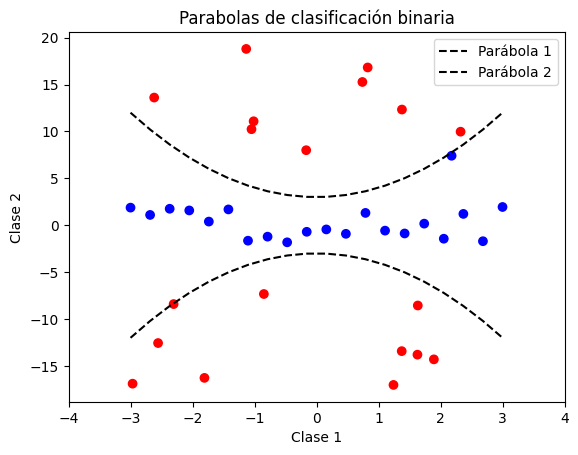

In [4]:
# np.random.seed(42)

# Definir las parábolas
x = np.linspace(-3, 3, 20)
parabola1 = x**2 + 3
parabola2 = -(x**2) - 3

# Generar los puntos entre las parábolas
X_inner = np.column_stack((x, np.random.uniform(-2, 2, size=20)))
y_inner = np.ones(20)

# Generar los puntos por encima y por debajo de las parábolas
X_outer = np.column_stack((np.random.uniform(-3, 3, size=20), 
            np.concatenate((np.random.uniform(-7, -20, size = 10), np.random.uniform(7, 20, size = 10)), axis=None)))
y_outer = np.ones(20) * -1

# Concatenar los datos
X_2 = np.concatenate((X_inner, X_outer), axis=0)
y_2 = np.concatenate((y_inner, y_outer), axis=0)

# Etiquetar los puntos según si están dentro, entre o fuera de las parábolas
is_inside = np.logical_and(X_2[:, 1] > (X_2[:, 0]**2 + 3), X_2[:, 1] < -(X_2[:, 0]**2) - 3)
is_between = np.logical_and(X_2[:, 1] < (X_2[:, 0]**2 + 3), X_2[:, 1] > -(X_2[:, 0]**2) - 3)
colors = np.where(is_inside, 'red', np.where(is_between, 'blue', 'red'))

# Visualizar los datos
plt.scatter(X_2[:, 0], X_2[:, 1], c=colors)
plt.plot(x, parabola1, c='black', linestyle='--', label='Parábola 1')
plt.plot(x, parabola2, c='black', linestyle='--', label='Parábola 2')
plt.xlim(-4, 4)
plt.xlabel('Clase 1')
plt.ylabel('Clase 2')
plt.legend()
plt.title('Parabolas de clasificación binaria')
plt.show()


## Asignación 3

Implemente una clase que permita ajustar un modelo de Máquinas de Vectores de Soporte. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Debe de poder utilizar un kernel de identidad o de RBF.
- Debe almacenar los vectores de soporte.

In [5]:
class SVM:
    def __init__(self, kernel: str = "identity", degree = 6):
        self.kernel = kernel
        self.y = None
        self.degree = degree

    def _kernel(self, X_1, X_2):
        if self.degree == 1:
            return np.dot(X_1, X_2)
        else:
            return (1 + np.dot(X_1, X_2))**self.degree

    def fit(self, X: np.ndarray, y: np.ndarray):
        n, d = X.shape
        self.y = y

        if self.kernel == "identity":
            p = np.zeros((d+1))
            b = 1
            c = np.ones((n))
            Q = np.identity(d+1)
            Q[0,0] = 0
            
            bx = np.concatenate((np.full((n,1), b), X), axis=1)
            A = np.multiply(bx, y[:, None])

            u = solve_qp(Q, p, -A, c, solver='scs')

            return u
            
        elif self.kernel == "poly":

            Q = np.zeros((n, n))

            for i in range(n):
                for j in range(n):
                    Q[i][j] = (self.y[i] * self.y[j]) * self._kernel(X[i], X[j])
            
            Q = cvxopt.matrix(Q)
            ones = cvxopt.matrix(-np.ones(n))
            A = cvxopt.matrix(np.vstack((y.T, -y, np.identity(n))))
            zeros = cvxopt.matrix(np.zeros(n + 2))
            
            solution = cvxopt.solvers.qp(Q, ones, -A, zeros)

            alphas = np.array(solution['x']).flatten()

            print(alphas)
            indices = []
            for i in range(n):
                if alphas[i] > 1e-5:
                    indices.append(i)
            alphas = alphas[alphas > 0]

            n = alphas.shape[0]
            b = 0
            for i in range(n):
                sum_b = 0
                for j in range(n):
                    sum_b += alphas[j] * y[j] * self._kernel(X[i], X[j])
                b = y[i] - sum_b

            return indices, np.concatenate((np.array([b]), alphas))
    

    def predict(self, X: np.ndarray, weights: np.ndarray):
        b = weights[0]
        w = weights[1:]
        if self.kernel == "identity":
            y_pred = np.sign(np.dot(X, w))
            return y_pred
        elif self.kernel == "poly":
            y_pred = np.zeros((X.shape[0]))
            for i in range(X.shape[0]):
                for j in range(w.shape[0]):
                    y_pred[i] += w[j] * self.y[j] *self._kernel(X[i], X[j])
                y_pred[i] = np.sign(y_pred[i]+b)

            return y_pred

## Asignación 4

Entrene un modelo de SVM (utilizando la clase implementada anteriormente) utilizando el dataset generado en la asignación 1 y un kernel de identidad. Grafique las predicciones de su modelo y marque los puntos que son vectores de soporte.

In [6]:
svm = SVM(kernel="identity")
u = svm.fit(X, y)
y_pred = svm.predict(X, u)
y_pred

/root/venv/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/root/venv/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


array([ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1., -1., -1., -1., -1.])

In [7]:
confusion_matrix(y, y_pred)

array([[14,  0],
       [ 0,  6]])

In [8]:
slope = -u[2] / u[1]
intercept = u[1] / u[0]

# Crear puntos para graficar la línea del hiperplano
x_hiper = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 20)
y_hiper = slope * x_hiper + intercept


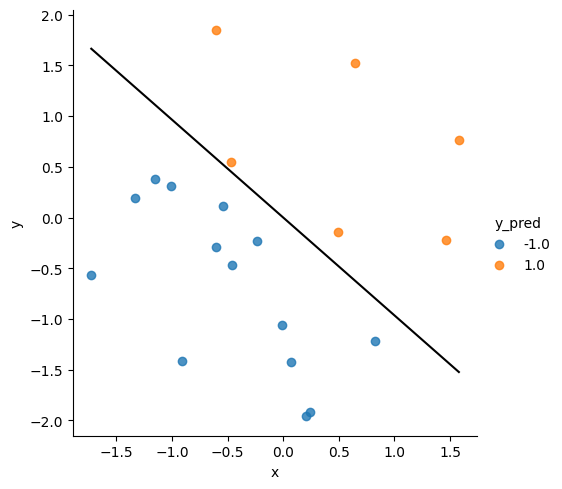

In [9]:
df = pd.DataFrame({'x': X[:, 0], 'y': X[:, 1], 'y_pred': y_pred})
sns.lmplot(data=df, x = 'x', y = 'y', hue= 'y_pred', fit_reg=False)
plt.plot(x_hiper, y_hiper, 'k-', label='Hiperplano de Separación')

## Asignación 5

Entrene un modelo de SVM (utilizando la clase implementada anteriormente) utilizando el dataset generado en la asignación 2 y un kernel de RBF. Grafique las predicciones de su modelo y marque los puntos que son vectores de soporte.

In [10]:
svm = SVM(kernel="poly", degree = 2)
indices, alphas = svm.fit(X_2, y_2)
print(alphas)
y_pred2 = svm.predict(X_2, alphas)
print(y_pred2)

[8.44035673e-09 3.83313818e-09 7.02633100e-09 5.42090345e-09
 2.86275854e-09 6.54001079e-09 2.74666503e-08 5.03969097e-09
 3.67548533e-04 3.10496595e-09 2.79410070e-09 3.34715482e-09
 4.41410809e-09 2.75666165e-09 3.02917445e-09 2.55265597e-09
 4.37060525e-09 4.03578778e-09 5.82904729e-09 3.89228897e-04
 8.30807851e-10 6.46216544e-11 5.94519866e-11 7.80164241e-11
 5.60324001e-11 9.29793434e-11 8.60589832e-11 9.92168917e-11
 6.03131088e-04 5.76536592e-10 1.53744460e-04 7.22969389e-11
 1.78455265e-10 9.02124967e-11 4.31902685e-11 2.52973465e-10
 1.18341512e-10 6.29537017e-11 2.48261565e-10 1.72993864e-09]
[1.37907092e+00 8.44035673e-09 3.83313818e-09 7.02633100e-09
 5.42090345e-09 2.86275854e-09 6.54001079e-09 2.74666503e-08
 5.03969097e-09 3.67548533e-04 3.10496595e-09 2.79410070e-09
 3.34715482e-09 4.41410809e-09 2.75666165e-09 3.02917445e-09
 2.55265597e-09 4.37060525e-09 4.03578778e-09 5.82904729e-09
 3.89228897e-04 8.30807851e-10 6.46216544e-11 5.94519866e-11
 7.80164241e-11 5.60324

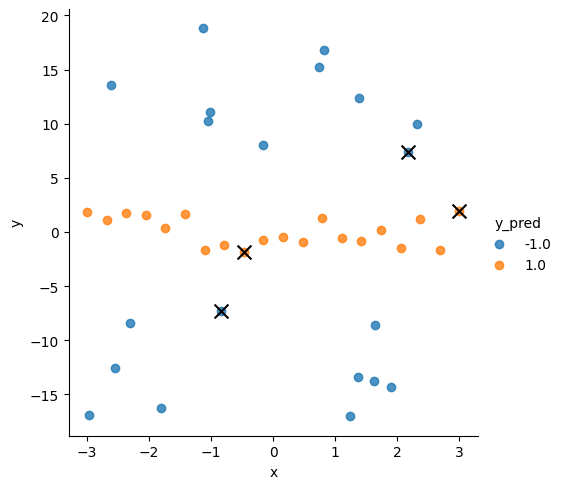

In [11]:
df = pd.DataFrame({'x': X_2[:, 0], 'y': X_2[:, 1], 'y_pred': y_pred2})
SV = X_2[indices]
sns.lmplot(data=df, x = 'x', y = 'y', hue= 'y_pred', fit_reg=False)
plt.scatter(SV[:,0], SV[:,1], color = 'black', marker = 'x', s = 100)
#sns.lmplot(data = df_sv, x = 'X', y = 'Y', fit_reg=False )

In [12]:
confusion_matrix(y_2, y_pred2)

array([[20,  0],
       [ 0, 20]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37dcd1d2-d5e1-4342-9e37-7d7795368fce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>